In [12]:
import xarray as xr
import numpy as np
import rioxarray as rx
import os
from matplotlib import pyplot as plt
import scipy.optimize as optimize
os.chdir('/disk/scratch/local.4/harry/TDX/')

In [13]:
def CSR(a):
    mean = np.mean(a, axis=0)
    resid = a - mean
    return np.cumsum(resid,axis=0)

def get_CSR(a):
    return xr.apply_ufunc(CSR, a)

asc = xr.open_dataset('intensity/nc/ascending.nc')
desc = xr.open_dataset('intensity/nc/descending.nc')
DEM = xr.open_dataset('DEM_timeseries/DEM_timeseries.nc')
DEM = DEM.isel(t=[0,1,2,3,4,5,6,6,7,8,10,11,12,13,14,15,18,19,20,21])
UAV = '/exports/csce/datastore/geos/users/s1332488/Chapter3/intensity/UAV_change_1m_masked.tif'
uav = rx.open_rasterio(UAV).sel(band=1).drop('band').rio.reproject('EPSG:4326').rename({'x':'lon','y':'lat'})
uav = uav.where(uav > -100).rename('uav')

LAT,LON = DEM.lat, DEM.lon
asc = get_CSR(asc).intensity.max(dim='t').rename('A').interp(lat=LAT,lon=LON)
desc = get_CSR(desc).intensity.max(dim='t').rename('D').interp(lat=LAT,lon=LON)
height = get_CSR(DEM.height).max(dim='t')
trend = DEM.height.polyfit('t',1).sel(degree=1).polyfit_coefficients 
DELTA = DEM.t[-1] - DEM.t[0]
trend = (trend * DELTA.astype(np.float64)).rename('trend')
# coh = get_CSR(DEM.coherence).max(dim='t')
uav = uav.interp(lat=LAT,lon=LON)


ds = xr.merge([uav,height,trend,asc,desc])

/exports/csce/datastore/geos/users/s1332488/minibonda/envs/XR/lib/python3.7/site-packages/xarray/core/nputils.py:169: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


In [3]:
ds = ds.coarsen(lat=3,lon=3,boundary='trim').mean()

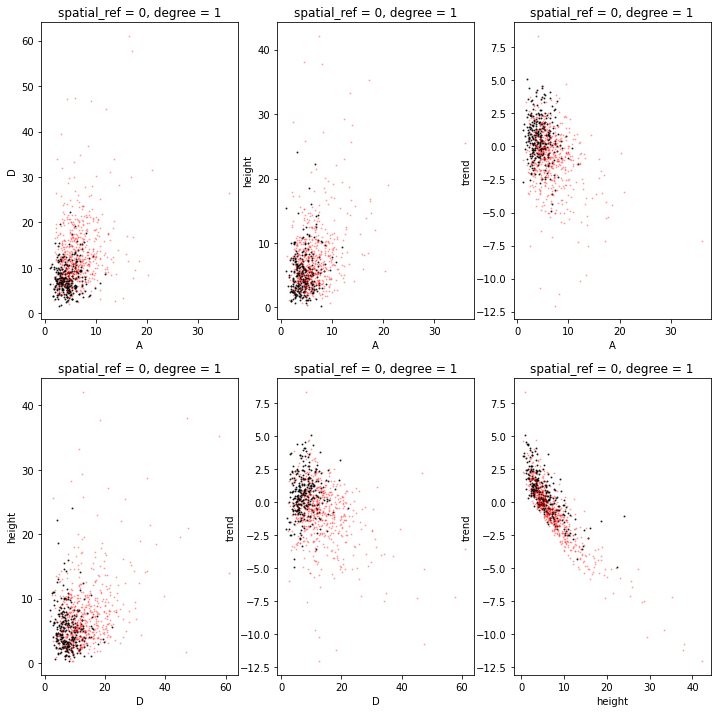

In [9]:
loss = ds.where(ds.uav < -2)
other = ds.where(ds.uav >= 2)
def scatplot(A,B):
    
    other.plot.scatter(x=A,y=B,s=1,color='black',alpha=0.75)
    loss.plot.scatter(x=A,y=B,color='red',s=1,alpha=0.25)
plt.figure(figsize=(12,12))
plt.subplot(2,3,1)
scatplot('A','D')
plt.subplot(2,3,2)
scatplot('A','height')
plt.subplot(2,3,3)
scatplot('A','trend')
plt.subplot(2,3,4)
scatplot('D','height')
plt.subplot(2,3,5)
scatplot('D','trend')
plt.subplot(2,3,6)
scatplot('height','trend')
plt.savefig('/home/s1332488/Chapter3/Figures/combined_features.png')



Optimization terminated successfully.
Correlation: 
0.47085335290364283


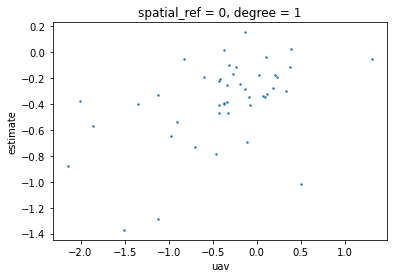

In [41]:
X,Y = 1,1

with ds.coarsen(lat=X,lon=Y,boundary='trim').mean() as data:

    def model(p):
        return p[0]*data.height + p[1]*data.trend + p[2]*data.A + p[3]*data.D + p[4]

    def cost_fn(p):
        estimate = model(p)
        resid = estimate - data.uav
        return np.sqrt((resid**2).sum())
    
    p = optimize.minimize(cost_fn,[-1,-1,-1,-1,0])
    print(p.message)
    data['estimate'] = model(p.x)
    data.plot.scatter(x='uav',y='estimate',s=2)
    print('Correlation: ')
    print(xr.corr(data.uav,data.estimate).values)

In [15]:
xx,yy = 10,10
with ds.coarsen(lat=xx,lon=yy,boundary='trim').mean() as data:
    X = data[['uav','height','trend','A','D']].to_array()
    np.save('data',X)

In [11]:
ds

<xarray.Dataset>
Dimensions:      (lat: 261, lon: 313)
Coordinates:
    spatial_ref  int64 0
  * lat          (lat) float64 -11.0 -11.0 -11.0 -11.0 ... -11.06 -11.06 -11.06
  * lon          (lon) float64 -69.76 -69.76 -69.76 ... -69.68 -69.68 -69.68
    degree       int64 1
Data variables:
    uav          (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    height       (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    trend        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    A            (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    D            (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref
    _FillValue:    -3.4028235e+38